In [1]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [2]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def extract_features(image, vector_size=32):
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print('Error: ', e)
        return None

    return dsc

def cluster_features(features, k):
    kmeans = KMeans


In [3]:
DATA_PATH = '../data/cifar-10-batches-py/'

data_dict = unpickle(DATA_PATH + "data_batch_1")

images = data_dict[b"data"]

labels = data_dict[b"labels"]

meta = unpickle(DATA_PATH + 'batches.meta')

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [5]:
from sklearn import svm

clf = svm.SVC(kernel='linear')

clf.fit(X_train, y_train)


SVC(kernel='linear')

In [6]:
y_pred = clf.predict(X_test)

In [7]:
from sklearn import metrics

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.2985


In [8]:
import matplotlib.pyplot as plt

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_images(images, true_labels, pred_labels, k):
    plt.figure(figsize=(10,10))
    indices = np.random.choice(range(len(images)), k)
    for i, idx in enumerate(indices):
        plt.subplot(k//2, 2, i+1)
        img = np.reshape(images[idx], (32, 32, 3))
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(f"True: {class_names[true_labels[idx]]}, Pred: {class_names[pred_labels[idx]]}")
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()


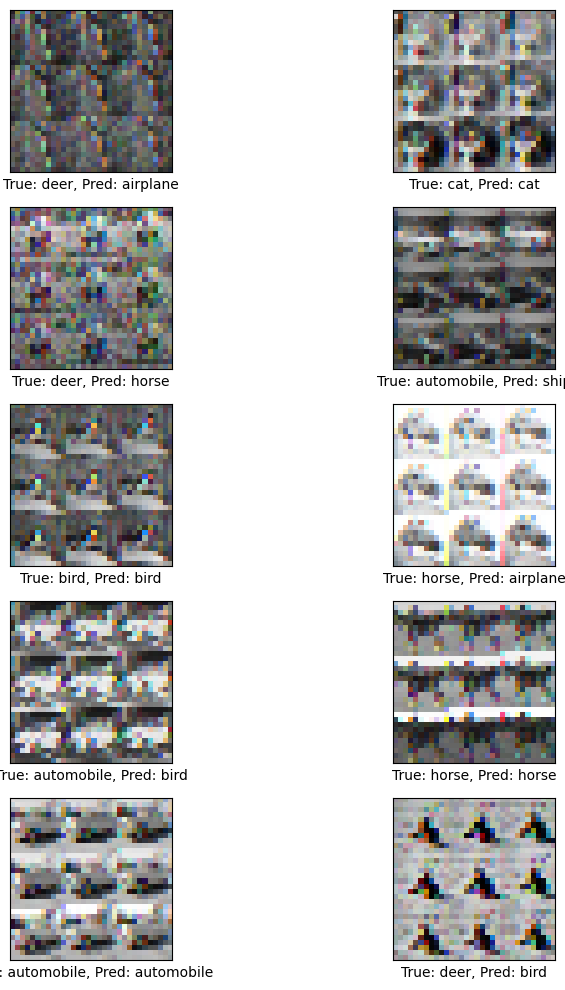

In [9]:
plot_images(X_test, y_test, y_pred, k=10)


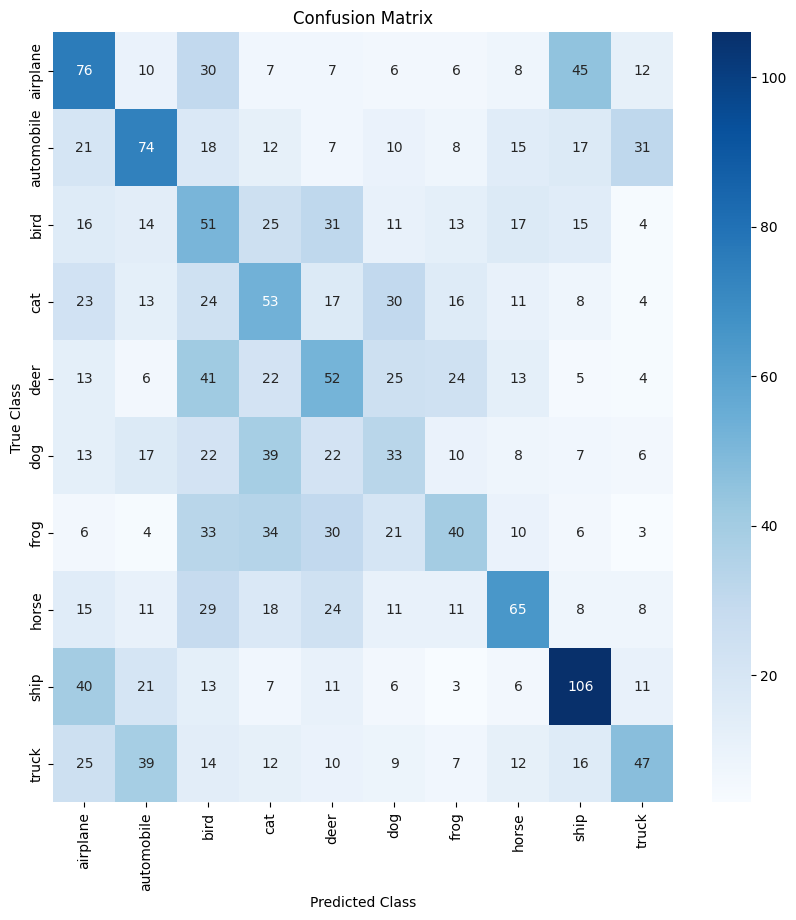

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Visualiser la matrice de confusion
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


In [11]:
import cv2
import numpy as np

def extract_color_histogram(image, bins=(8, 8, 8)):
    # Extrait un histogramme 3D de couleur de l'image
    # en utilisant le nombre de `bins` donné par canal de couleur
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    
    # Normalise l'histogramme
    cv2.normalize(hist, hist)
    
    # Retourne l'histogramme sous forme d'un vecteur à une dimension
    return hist.flatten()


In [13]:
import pickle

def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    images = dict[b'data']
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels = dict[b'labels']
    return images, labels

images, labels = load_cifar10_batch(DATA_PATH + "data_batch_1")

# Maintenant vous pouvez extraire les histogrammes de couleur
features = []
for image in images:
    histogram = extract_color_histogram(image)
    features.append(histogram)

features = np.array(features)


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Supposons que vous ayez stocké tous vos histogrammes de couleur dans une liste `features`
# et que vous ayez les étiquettes correspondantes dans une liste `labels`.

# Convertir les listes en tableaux numpy pour la compatibilité avec scikit-learn
features = np.array(features)
labels = np.array(labels)

# Divisez les données en un ensemble d'apprentissage et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Créez un objet RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)

# Entraînez le classificateur sur vos données
clf.fit(X_train, y_train)

# Faites des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

# Évaluez la précision de votre modèle
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.3805


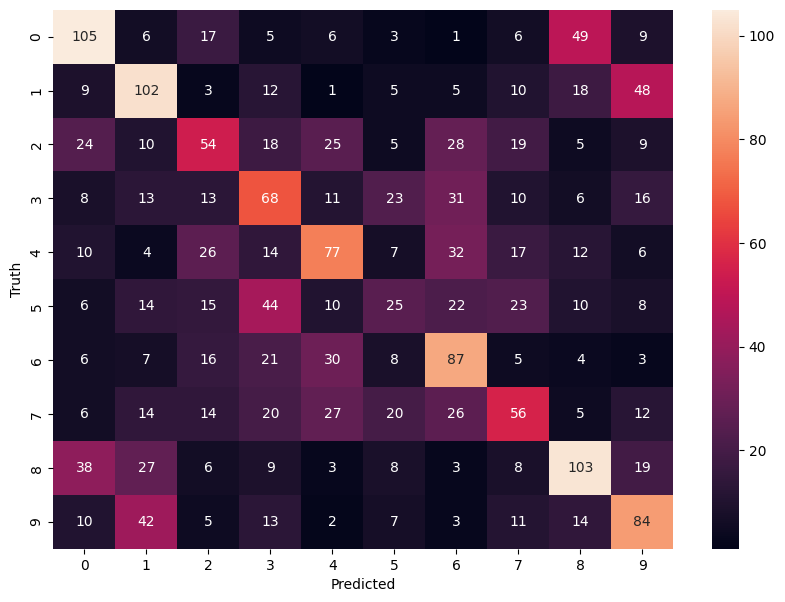

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Faites vos prédictions
y_pred = clf.predict(X_test)

# Créez la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichez la matrice de confusion avec seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


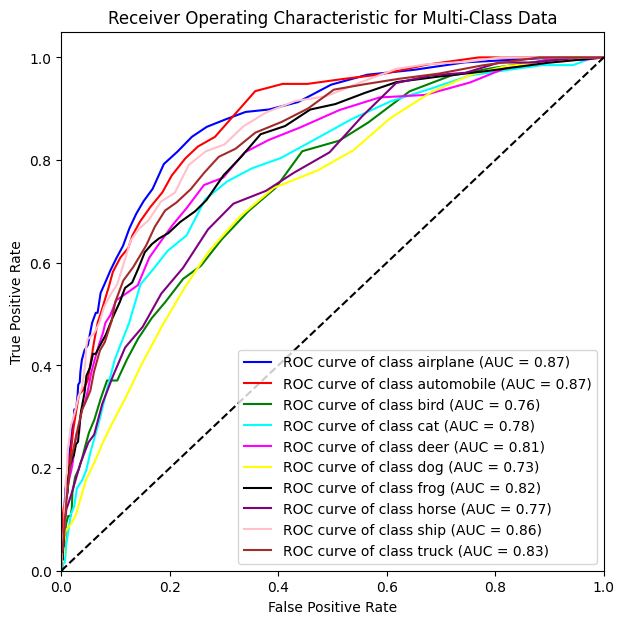

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binariser les labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = clf.predict_proba(X_test)  # Remplacez ici par votre classificateur et vos données de test

# Initialiser le style du cycle
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'pink', 'brown'])
class_names = range(10)  # Remplacez ici par vos vrais noms de classe

plt.figure(figsize=(7, 7))

for i, color in zip(range(len(class_names)), colors):
    # Calculer la courbe ROC pour la i-ème classe
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])

    # Calculer l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Tracer la courbe ROC
    plt.plot(fpr, tpr, color=color, label=f'ROC curve of class {meta[b"label_names"][class_names[i]].decode("utf-8")} (AUC = {roc_auc:.2f})')

# Tracer la ligne de hasard
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Data')
plt.legend(loc="lower right")
plt.show()
